<a href="https://colab.research.google.com/github/pyoph/projetNLP/blob/main/projetNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from xgboost import XGBClassifier
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
os.getcwd()

'/content'

In [172]:
#Ouverture des fichiers
tws = pd.read_csv("/content/drive/MyDrive/transcriptions_with_sex (1).csv",sep =",")
fws = pd.read_csv("/content/drive/MyDrive/fws.csv",sep = ";")

In [118]:
fws.head()
tws.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [25]:
fws.shape[0]

6946

In [26]:
fws.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


In [8]:
tws.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [173]:
#Calcul du pourcentage de valeurs manquantes pour le fichier tws

total_missing = tws.isna().sum().sum()

total_cells = tws.size

percentage_missing = (total_missing / total_cells) * 100

print(percentage_missing)

0.0


In [174]:
#Calcul du pourcentage de valeurs manquantes pour le fichier fws

total_missing = fws.isna().sum().sum()

total_cells = fws.size

percentage_missing = (total_missing / total_cells) * 100

print(percentage_missing)

0.0


In [175]:
#Récupération des features

tws['surname'] = tws['groundtruth'].str.extract(r'surname:\s*([^\s]+)')
tws['firstname'] = tws['groundtruth'].str.extract(r'firstname:\s*([^\s]+)')
tws['occupation'] = tws['groundtruth'].str.extract(r'occupation:\s*([^\s]+)')
tws['link'] = tws['groundtruth'].str.extract(r'link:\s*([^\s]+)')
tws['age'] = tws['groundtruth'].str.extract(r'age:\s*([^\s]+)')
tws['employer'] = tws['groundtruth'].str.extract(r'employer:\s*([^\s]+)')
tws['nom'] = tws['prediction'].str.extract(r'nom:\s*([^\s]+)')
tws['prénom'] = tws['prediction'].str.extract(r'prénom:\s*([^\s]+)')
tws['date_naissance'] = tws['prediction'].str.extract(r'date_naissance:\s*([^\s]+)')
tws['relation'] = tws['prediction'].str.extract(r'relation:\s*([^\s]+)')


In [176]:
#Traitement des données des champs : uniformisation
nltk.download('wordnet')
# Initialiser le lemmatizer WordNet
lemmatizer = WordNetLemmatizer()

# Définir des règles de remplacement pour la normalisation des mots
rules = {
    'mére': 'mère',
    'domest.': 'domestique',
    'enf' : 'enfant',
    'ch.' : 'chef',
    'ép' : 'épouse',
    's' : 'néant',
    's.p':'néant',
    's.p.' : 'néant',
    'sans' : 'néant',
    'sp' : 'néant',
    'cult' : 'cultivateur',
    'cultivat' : 'cultivatrice',
    'cultiv' : 'cultivateur'


}

# Nettoyage des champs 'occupation', 'relation' et 'link' en utilisant les règles de remplacement
tws['occupation'] = tws['occupation'].apply(lambda x: ' '.join([lemmatizer.lemmatize(rules.get(word, word).lower()) for word in str(x).split()]) if pd.notnull(x) else '')
tws['relation'] = tws['relation'].apply(lambda x: ' '.join([lemmatizer.lemmatize(rules.get(word, word).lower()) for word in str(x).split()]) if pd.notnull(x) else '')
tws['link'] = tws['link'].apply(lambda x: ' '.join([lemmatizer.lemmatize(rules.get(word, word).lower()) for word in str(x).split()]) if pd.notnull(x) else '')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [177]:
#Tableau croisé dynamique avec le genre et link
link_gender_table = tws.pivot_table(index='link', columns='sex', aggfunc='size', fill_value=0)



In [178]:
#Tableau croisé dynamique avec l'occupation et link
occupation_gender_table = tws.pivot_table(index='occupation', columns='sex', aggfunc='size', fill_value=0)

# Afficher le tableau croisé
print(occupation_gender_table)

sex              ambigu  femme  homme
occupation                           
                      0     20     22
agent                 0      0      1
argentière            0      1      0
blanchiseuse          0      1      0
boulanger             0      1      0
buraliste             0      0      1
cantonnier            0      0      1
charcutier            0      0      1
charretier            0      0      1
clerc                 0      0      1
coiffeur              0      0      1
couturière            0      1      0
couvreur              0      0      1
culivateur            0      0      1
cullotière            0      1      0
cultivateur           1      0     17
cultivatrice          0      1      1
domestique            0      6      5
déposit               0      1      0
employé               0      0      2
employée              0      1      0
femme                 0      1      0
forgeron              0      0      2
garde                 0      0      2
garde-champê

In [179]:
#Table pour relation

#Tableau croisé dynamique avec l'occupation et link
relation_gender_table = tws.pivot_table(index='relation', columns='sex', aggfunc='size', fill_value=0)

# Afficher le tableau croisé
print(relation_gender_table)

sex       ambigu  femme  homme
relation                      
               1     38     41
"              1      1      2
''             0      2      0
'h             0      0      1
a              1      0      2
...          ...    ...    ...
rouher         0      0      1
sa             0      1      0
se             0      1      0
épouse         0      1      0
éprest         0      0      1

[64 rows x 3 columns]


In [170]:
#Préparation des données pour la création des wordclouds

listeNoms = []

for i in range(0,len(list(tws['surname']))) :
  listeNoms.append(str(tws['surname'][i]))

texte = " ".join(listeNoms)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Affichage du nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

KeyError: 17

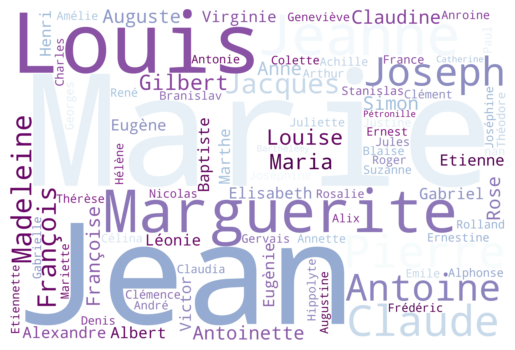

In [29]:
#Wordcloud pour la liste des prénoms

#Enregistrement des prénoms dans une liste pour les afficher dans un Wordcloud
listePrenoms = []

for i in range(0,len(list(tws['firstname']))) :
  listePrenoms.append(str(tws['firstname'][i]))

texte = " ".join(listePrenoms)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Affichage du nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

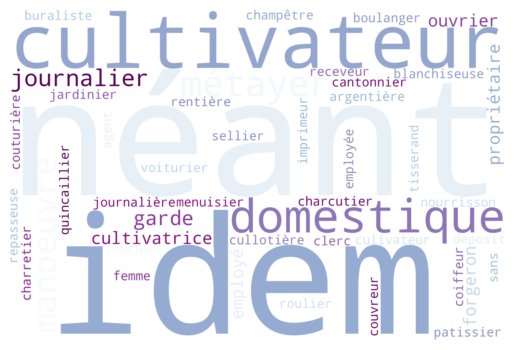

In [30]:
#Enregistrement des occupations dans une liste pour les afficher dans un Wordcloud
listeOccupations = []

for i in range(0,len(list(tws['occupation']))) :
  listeOccupations.append(str(tws['occupation'][i]))

texte = " ".join(listeOccupations)

word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        colormap="BuPu",
        collocations=False,
        stopwords=set(),
        ).generate(texte)

# Affichage du nuage de mots
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [180]:
#Première approche on cherche que est le genre à partir du prénom en fonction du nombre d'hommes ou de femmes qui le portent

# Détermination du genre majoritaire d'un prénom
def determine_genre(prenom):
    # Recherche du prénom dans le DataFrame fws
       if not str(prenom).strip() == '':
        prenom_lower = prenom.lower()  # Convertir le prénom en minuscules pour la recherche insensible à la casse
        match = fws[fws['firstname'].str.lower().str.contains(prenom_lower, na=False)]

        if not match.empty:
            # Si le prénom est trouvé dans fws, détermination du genre majoritaire
            hommes = match['male'].sum()
            femmes = match['female'].sum()
            if hommes > femmes:
                return 'homme'
            elif hommes < femmes:
                return 'femme'
            else:
                return 'Indéterminé'  # En cas d'égalité
        else:
            return 'Inconnu'

#Initialisation des champs genreGt et genrePred
tws['genreGt'] = ''
tws['genrePred'] = ''


for i in range(0,len(list(tws['firstname']))) :
  tws['genreGt'][i] = determine_genre(str(tws['firstname'][i]))
  tws['genrePred'][i] = determine_genre(str(tws['prénom'][i]))


tws.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,relation,genreGt,genrePred
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Marie,idem,fille,30,NaN,Chardon,Marie,30,,femme,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Louis-Jean,néant,chef,67,NaN,Lhopital,Louis,67,,Inconnu,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Marie,idem,idem,15,idem,Pyrin,Marie,55,d,femme,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Marie,,femme,NaN,NaN,Lavocat,Marie,1875,,femme,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Marguerite,,,78,NaN,Benne,Marguerite,78,'',femme,femme


In [184]:
#Isolement des lignes avec sexe amigu
tws_ambigu = tws[tws['sex'] == 'ambigu']

tws = tws[~tws['sex'].str.contains('ambigu', case=False, na=False)]


In [127]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,relation,genreGt,genrePred
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33,chef,homme,homme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66,id,femme,femme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804,chef,homme,Inconnu
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84,d,femme,femme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2,"""",homme,homme


In [181]:
#Calcul des accuracy
# Calculer l'accuracy pour la colonne 'genreGt'
accuracy_genreGt = (tws['genreGt'] == tws['sex']).mean() * 100
print("Accuracy de genreGt : {:.2f}%".format(accuracy_genreGt))

# Calculer l'accuracy pour la colonne 'genrePred'
accuracy_genrePred = (tws['genrePred'] == tws['sex']).mean() * 100
print("Accuracy de genrePred : {:.2f}%".format(accuracy_genrePred))


Accuracy de genreGt : 92.53%
Accuracy de genrePred : 82.99%


In [ ]:
fws.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


([<matplotlib.axis.XTick at 0x7ac4bd1155d0>,
 [Text(0, 0, 'femme'), Text(1, 0, 'homme')])

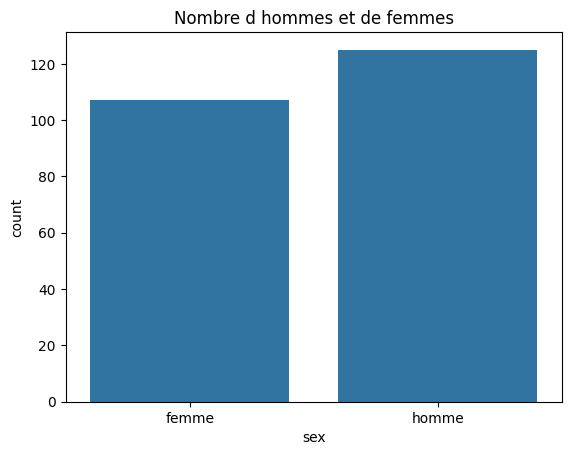

In [ ]:
#Statistiques descriptives

#Sexe

sns.countplot(x='sex',data = tws)

plt.title('Nombre d hommes et de femmes')

plt.xticks([0,1],('femme','homme'))

In [185]:
#Préparation des données

#Encodage de la variable sex avec 0 ou 1 0 = femme 1 = homme
Y = list(tws['sex'])
encoder= LabelEncoder()

Y = encoder.fit_transform(Y)


In [186]:
Y

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [187]:
#Vectorisation des champs
def vectoriserChamp(champ) :
  tws[champ].fillna('', inplace=True)
  return TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit_transform(tws[champ])



In [188]:
#Création des objets TfId pour le champ groundtruth
tfidf_features_firstname =vectoriserChamp('firstname')
tfidf_features_occupation = vectoriserChamp('occupation')
tfidf_features_link = vectoriserChamp('link')

In [189]:
#Création des objets TfId pour le champ prediction
tfidf_features_firstnamePred =vectoriserChamp('prénom')
tfidf_features_occupationPred = vectoriserChamp('occupation')
tfidf_features_linkPred = vectoriserChamp('relation')

In [190]:
#Création de la matrice de variables explicatives
def creerVecteurVariablesExplicatives() :
  X = np.concatenate((tfidf_features_firstname.toarray(), tfidf_features_occupation.toarray()), axis=1)
  X = np.concatenate((X,tfidf_features_link.toarray()),axis = 1)
  return X


In [191]:
#Création de la matrice de variables explicatives champ prédiction
def creerVecteurVariablesExplicativesPred() :
  X = np.concatenate((tfidf_features_firstnamePred.toarray(), tfidf_features_linkPred.toarray()), axis=1)
  X = np.concatenate((X,tfidf_features_occupationPred.toarray()),axis = 1)
  return X

In [192]:
#Modèles
#Régression logisitique pour groundtruth
def regressionLogistique() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  logistic_regression_model = LogisticRegression()
  logistic_regression_model.fit(X_train, y_train)

  predictions = logistic_regression_model.predict(X_test)

  accuracy = logistic_regression_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return logistic_regression_model


In [139]:
#Régression logisitique pour prediction
def regressionLogistiquePred() :
  X = creerVecteurVariablesExplicativesPred()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  logistic_regression_model = LogisticRegression()
  logistic_regression_model.fit(X_train, y_train)

  predictions = logistic_regression_model.predict(X_test)

  accuracy = logistic_regression_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return logistic_regression_model

In [140]:
#Naive Bayes
def naiveBayes() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  NB_model= MultinomialNB()
  NB_model.fit(X_train,y_train)
  NB_y_pred = NB_model.predict(X_test)
  accuracy = NB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return NB_model


In [141]:
#Naive Bayes sur le champ prédiction
def naiveBayesPred() :
  X = creerVecteurVariablesExplicativesPred()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  NB_model= MultinomialNB()
  NB_model.fit(X_train,y_train)
  NB_y_pred = NB_model.predict(X_test)
  accuracy = NB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return NB_model


In [142]:
#Modèle XGLBoost
def XGLBoost() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  XGB_model = XGBClassifier(use_label_encoder= False)
  XGB_model.fit(X_train,y_train)
  XGB_y_pred = XGB_model.predict(X_test)
  accuracy = XGB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return XGB_model

In [143]:
#Modèle XGLBoost champ prédiction

def XGLBoostPred() :
  X = creerVecteurVariablesExplicativesPred()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  XGB_model = XGBClassifier(use_label_encoder= False)
  XGB_model.fit(X_train,y_train)
  XGB_y_pred = XGB_model.predict(X_test)
  accuracy = XGB_model.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return XGB_model

In [144]:
#Modèle Adaboost champ groundtruth
def adaboost() :
  X = creerVecteurVariablesExplicatives()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
  adaboost_clf.fit(X_train, y_train)
  y_pred = adaboost_clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy du modèle Adaboost : {:.2f}%".format(accuracy * 100))
  accuracy = adaboost_clf.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return adaboost_clf

In [145]:
#Modèle Adaboost champ prediction
def adaboostPred() :
  X = creerVecteurVariablesExplicativesPred()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
  adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
  adaboost_clf.fit(X_train, y_train)
  y_pred = adaboost_clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy du modèle Adaboost : {:.2f}%".format(accuracy * 100))
  accuracy = adaboost_clf.score(X_test, y_test)
  print("Accuracy:", accuracy)
  return adaboost_clf

In [146]:
modeleLogistique = regressionLogistique()

Accuracy: 0.8857142857142857


In [147]:
modeleLogistiquePred = regressionLogistiquePred()

Accuracy: 0.8285714285714286


In [148]:
NBModel = naiveBayes()

Accuracy: 0.8857142857142857


In [149]:
NBModelPred = naiveBayesPred()

Accuracy: 0.8857142857142857


In [150]:
modeleXGL = XGLBoost()

Accuracy: 0.9428571428571428


In [151]:
modeleXGLPred = XGLBoostPred()

Accuracy: 0.8857142857142857


In [153]:
modeleAdaboost = adaboost()

Accuracy du modèle Adaboost : 97.14%
Accuracy: 0.9714285714285714


In [154]:
modeleAdaboostPred = adaboostPred()

Accuracy du modèle Adaboost : 91.43%
Accuracy: 0.9142857142857143


In [115]:
#Fonction de prédiction d'une nouvelle entrée
def predictionNouvelleEntree (prenom,occupation,link,modele) :
  tws['firstname'].fillna('', inplace=True)
  tws['occupation'].fillna('', inplace=True)
  tws['link'].fillna('', inplace=True)
  tfidf_new_firstname = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['firstname'])
  tfidf_new_occupation = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['occupation'])
  tfidf_new_link = TfidfVectorizer(analyzer='char', ngram_range=(2, 3)).fit(tws['link'])
  X_new_firstname = tfidf_new_firstname.transform([prenom])
  X_new_occupation = tfidf_new_occupation.transform([occupation])
  X_new_link = tfidf_new_link.transform([link])
  X_new = np.concatenate((X_new_firstname.toarray(), X_new_occupation.toarray(), X_new_link.toarray()), axis=1)
  prediction = modele.predict(X_new)
  return prediction




In [ ]:
tws.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,Chardon,Marie,idem,fille,30,NaN,Chardon,Marie,30
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,Lhopital,Louis-Jean,sp,chef,67,NaN,Lhopital,Louis,67
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,Papin,Marie,idem,idem,15,idem,Pyrin,Marie,55
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,Lavocat,Marie,,femme,NaN,NaN,Lavocat,Marie,1875
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,Benne,Marguerite,,,78,NaN,Benne,Marguerite,78


In [193]:
#Test prédiction nouvelle entrée modèle Naive Bayes
predictionNB = predictionNouvelleEntree('Marie','menuisier','chef',NBModel)
print(predictionNB)

[1]


In [194]:
#Test sur une entrée modèle logistique
prediction = predictionNouvelleEntree('Marie','menuisier','chef',modeleLogistique)
print(prediction)


[0]


In [195]:
#Test sur une entrée modèle XGL
prediction = predictionNouvelleEntree('Marie','menuisier','chef',modeleXGL)
print(prediction)


[0]


In [197]:
#Test sur une entrée modèle Adaboost
prediction = predictionNouvelleEntree('Marie','menuisier','chef',modeleAdaboost)
print(prediction)


[0]


In [209]:
#Prédictions pour les entrées ambigu avec Naive Bayes
predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntree(row['firstname'], row['occupation'], row['link'],NBModel)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])



In [210]:
#Prédictions pour les entrées ambigu avec le modèle logisitique
predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntree(row['firstname'], row['occupation'], row['link'],modeleLogistique)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])


In [211]:
#Prédictions pour les entrées ambigu avec le modèle XGL Boost

predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntree(row['firstname'], row['occupation'], row['link'],modeleXGL)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])



In [213]:
#Prédictions pour les entrées ambigu avec le modèle Ada Boost

predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntree(row['firstname'], row['occupation'], row['link'],modeleAdaboost)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])

In [212]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,relation,genreGt,genrePred,sex_ambigu
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33,chef,homme,homme,femme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66,id,femme,femme,homme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804,chef,homme,Inconnu,femme
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84,d,femme,femme,homme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2,"""",homme,homme,femme


In [216]:
#Réseau de neurones LSTM sur le champ groundtruth
X = creerVecteurVariablesExplicatives()

#Division en échantillon d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Construction du modèle RNN
inputs = Input(shape=(1, X_train.shape[1]))  # la forme devient (batch_size, timesteps, input_dim)
x = LSTM(units=32)(inputs)  # Couche LSTM
outputs = Dense(units=1, activation='sigmoid')(x)  # Couche de sortie

# Création du modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
model.compile(optimizer= 'adam', loss='binary_crossentropy' ,metrics=['accuracy'])

# Ajouter une nouvelle dimension pour représenter les pas de temps
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Entraînement du modèle
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
4/4 [==============================] - 3s 14ms/step - loss: 0.6901 - accuracy: 0.5888
Epoch 2/10
4/4 [==============================] - 0s 13ms/step - loss: 0.6749 - accuracy: 0.8832
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 0.6607 - accuracy: 0.8883
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: 0.6468 - accuracy: 0.9036
Epoch 5/10
4/4 [==============================] - 0s 12ms/step - loss: 0.6326 - accuracy: 0.9137
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6176 - accuracy: 0.9289
Epoch 7/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6019 - accuracy: 0.9442
Epoch 8/10
4/4 [==============================] - 0s 11ms/step - loss: 0.5850 - accuracy: 0.9543
Epoch 9/10
4/4 [==============================] - 0s 11ms/step - loss: 0.5675 - accuracy: 0.9543
Epoch 10/10
2/2 [==============================] - 1s 13ms/step - loss: 0.5617 - accuracy: 0.8286
Loss: 0.561745822429657
Accur

In [103]:
#Réseau de neurones LSTM sur le champ prediction
X = creerVecteurVariablesExplicatives()

#Division en échantillon d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Construction du modèle RNN
inputs = Input(shape=(1, X_train.shape[1]))  # la forme devient (batch_size, timesteps, input_dim)
x = LSTM(units=32)(inputs)  # Couche LSTM
outputs = Dense(units=1, activation='sigmoid')(x)  # Couche de sortie

# Création du modèle
model = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
model.compile(optimizer= 'adam', loss='binary_crossentropy' ,metrics=['accuracy'])

# Ajouter une nouvelle dimension pour représenter les pas de temps
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Entraînement du modèle
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
7/7 [==============================] - 6s 6ms/step - loss: 0.6873 - accuracy: 0.6548
Epoch 2/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.8985
Epoch 3/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6402 - accuracy: 0.9086
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6154 - accuracy: 0.9340
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.5886 - accuracy: 0.9340
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.5591 - accuracy: 0.9391
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.5277 - accuracy: 0.9442
Epoch 8/10
7/7 [==============================] - 0s 6ms/step - loss: 0.4948 - accuracy: 0.9442
Epoch 9/10
7/7 [==============================] - 0s 7ms/step - loss: 0.4605 - accuracy: 0.9492
Epoch 10/10
2/2 [==============================] - 1s 12ms/step - loss: 0.4465 - accuracy: 0.8857
Loss: 0.4464694559574127
Accuracy: 0.8

In [206]:
#Création de variables explicatives pour le champ groundtruth et détermination de la longueur de séquence adaptée
X = creerVecteurVariablesExplicatives()

#Division en échantillon d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
max_length = max(len(seq) for seq in X_train)
print("Longueur maximale des séquences:", max_length)


Longueur maximale des séquences: 961


In [207]:
#Exécution du réseau de neurones CNN sur les champs de prediction

TAILLE_SEQUENCE = 1
EMBED_SIZE = 961

# Création du modèle
model = Sequential()

# Ajout des couches
model.add(Conv1D(filters=256, kernel_size=4, padding='same', activation='relu', input_shape=(TAILLE_SEQUENCE, EMBED_SIZE)))
model.add(MaxPooling1D(pool_size=2, padding ='same'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding ='same'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding ='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()

# Remodelage des données d'entrée
#X_train_reshaped = X_train.reshape(X_train.shape[0], TAILLE_SEQUENCE, EMBED_SIZE)

# Ajout d'une nouvelle dimension pour représenter les pas de temps
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)
# Entraînement du modèle
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 1, 256)            984320    
                                                                 
 max_pooling1d_76 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_77 (Conv1D)          (None, 1, 64)             65600     
                                                                 
 max_pooling1d_77 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_78 (Conv1D)          (None, 1, 32)             8224      
                                                                 
 max_pooling1d_78 (MaxPooli  (None, 1, 32)           

In [204]:
#Création des variables explicatives pour le champ prédiction et détermination de la longueur de séquences adaptée
X = creerVecteurVariablesExplicativesPred()

#Division en échantillon d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

#Récupération de la longueur maximale des séquences
max_length = max(len(seq) for seq in X_train)
print("Longueur maximale des séquences:", max_length)

Longueur maximale des séquences: 1117


In [205]:
#Exécution du réseau de neurones CNN sur les champs de prediction

TAILLE_SEQUENCE = 1
EMBED_SIZE = 1117

# Création du modèle
model = Sequential()

# Ajout des couches
model.add(Conv1D(filters=256, kernel_size=4, padding='same', activation='relu', input_shape=(TAILLE_SEQUENCE, EMBED_SIZE)))
model.add(MaxPooling1D(pool_size=2, padding ='same'))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding ='same'))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding ='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Affichage de la structure du modèle
model.summary()

# Remodelage des données d'entrée
#X_train_reshaped = X_train.reshape(X_train.shape[0], TAILLE_SEQUENCE, EMBED_SIZE)

# Ajout d'une nouvelle dimension pour représenter les pas de temps
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)
# Entraînement du modèle
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 1, 256)            1144064   
                                                                 
 max_pooling1d_73 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_74 (Conv1D)          (None, 1, 64)             65600     
                                                                 
 max_pooling1d_74 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_75 (Conv1D)          (None, 1, 32)             8224      
                                                                 
 max_pooling1d_75 (MaxPooli  (None, 1, 32)           

In [ ]:
X_train.shape[1]

961

In [199]:
#Prédiction de nouvelle entrée pour un réseau de neurones
def predictionNouvelleEntreeNN(prenom, occupation, link, modele):
    # Prétraitement des nouvelles données
    tws['firstname'].fillna('', inplace=True)
    tws['occupation'].fillna('', inplace=True)
    tws['link'].fillna('', inplace=True)
    tfidf_new_firstname = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['firstname'])
    tfidf_new_occupation = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['occupation'])
    tfidf_new_link = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=1000).fit(tws['link'])

    X_new_firstname = tfidf_new_firstname.transform([prenom])
    X_new_occupation = tfidf_new_occupation.transform([occupation])
    X_new_link = tfidf_new_link.transform([link])

    # Convertir les données en séquences de caractéristiques
    X_new_firstname = X_new_firstname.toarray()
    X_new_occupation = X_new_occupation.toarray()
    X_new_link = X_new_link.toarray()

    # Concaténer les données prétraitées
    X_new = np.concatenate((X_new_firstname, X_new_occupation, X_new_link), axis=1)
    X_new_reshaped = np.expand_dims(X_new, axis=1)


    # Faire une prédiction sur les nouvelles données
    prediction = modele.predict(X_new_reshaped)

    return prediction


In [201]:
#Test de la prédiction de la nouvelle entrée avec le réseau de neurones LSTM
prediction = predictionNouvelleEntreeNN('Marie','menuisier','chef',model)

if prediction >= 0.5 :
  print("homme")
else :
  print("femme")

1/1 [==============================] - 3s 3s/step
homme


In [208]:
#Test de la prédiction de la nouvelle entrée avec le réseau de neurones CNN
prediction = predictionNouvelleEntreeNN('Marie','menuisier','chef',model)

if prediction >= 0.5 :
  print("homme")
else :
  print("femme")

1/1 [==============================] - 0s 202ms/step
homme


In [214]:
#Prédictions pour les entrées ambigu avec le réseau de neurones
predictions_ambigu = []

for index, row in tws_ambigu.iterrows():

    prediction = predictionNouvelleEntreeNN(row['firstname'], row['occupation'], row['link'],model)

    if prediction[0] == 0:
        tws_ambigu.at[index, 'sex_ambigu'] = 'homme'
    elif prediction[0] == 1:
        tws_ambigu.at[index, 'sex_ambigu'] = 'femme'

    predictions_ambigu.append(prediction[0])

1/1 [==============================] - 0s 39ms/step


In [217]:
tws_ambigu.head()

,subject_line,groundtruth,prediction,sex,surname,firstname,occupation,link,age,employer,nom,prénom,date_naissance,relation,genreGt,genrePred,sex_ambigu
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu,Daniel,Claude,journalier,chef,33,NaN,Demil,Claude,33,chef,homme,homme,femme
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu,Gorbinet,Jeanne,idem,chef,66,NaN,Gorbinet,Jeanne,66,id,femme,femme,homme
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu,Roumeau,Claude,cultivateur,chef,30,NaN,Roumeau,Vaude,1804,chef,homme,Inconnu,femme
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu,Chardon,Marie,idem,chef,84,NaN,Chardon,Marie,84,d,femme,femme,homme
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu,Grillé,Emile,idem,idem,2,idem,d,Emile,2,"""",homme,homme,femme
